<a href="https://colab.research.google.com/github/marlenaalvino/dog-breed-classifier/blob/main/dog_breed_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Import the necessary libraries
import os
import json
import timm
import torch
import shutil
import random
import numpy as np
import seaborn as sns
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
from contextlib import nullcontext
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
from timm.data import resolve_model_data_config
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Set the random seeds for reproducibility
SEED = 27
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# Initialize the data paths
ORIGINAL_DATA_PATH = "data/raw/images"
SPLIT_DATA_PATH = "data/processed"

# Initialize the split ratios and number of classes
VALID_SIZE = 0.15
TEST_SIZE = 0.15
NUM_CLASSES = 120

# Initialize the data pipeline hyperparameters
BATCH_SIZE = 32
NUM_WORKERS = 2

In [6]:
# Returns True if the file at the specified path is an uncorrupted image, False otherwise
def is_image(path):
    try:
        Image.open(path).verify()
        return True
    except Exception as e:
        return False

# Performs a stratified split of the data into training, validation, and test sets
def split_data(input_path, output_path, valid_size=VALID_SIZE, test_size=TEST_SIZE):
    # Remove any existing data split directories
    if os.path.exists(output_path):
        shutil.rmtree(output_path)

    # Create the train, valid, and test directories
    for dir in ["train", "valid", "test"]:
        os.makedirs(os.path.join(output_path, dir), exist_ok=True)

    # Iterate through each dog breed directory
    breed_dirs = [d for d in os.listdir(input_path) if os.path.isdir(os.path.join(input_path, d))]
    for breed in breed_dirs:
        # Get all the image names for the current breed
        breed_path = os.path.join(input_path, breed)
        images = [f for f in os.listdir(breed_path) if is_image(os.path.join(breed_path, f))]

        # Split the images into (train + validation) and test sets
        train_valid_imgs, test_imgs = train_test_split(images, test_size=test_size, random_state=27)

        # Further split the (train + validation) image set into train and validation sets
        train_imgs, valid_imgs = train_test_split(train_valid_imgs, test_size=valid_size/(1-test_size), random_state=27)

        # Copy the images into their appropriate locations
        for set, img_list in zip(['train', 'valid', 'test'], [train_imgs, valid_imgs, test_imgs]):
            set_breed_path = os.path.join(output_path, set, breed)
            os.makedirs(set_breed_path, exist_ok=True)
            for img in img_list:
                shutil.copy(os.path.join(breed_path, img), os.path.join(set_breed_path, img))

# Split the data into training, validation, and test sets
split_data(ORIGINAL_DATA_PATH, SPLIT_DATA_PATH, VALID_SIZE, TEST_SIZE)

In [7]:
# Load the EfficientNet-B3 model, pretrained on ImageNet-1K, and replace its head
model = timm.create_model("efficientnet_b3", pretrained=True, num_classes=NUM_CLASSES)

# Retrieve the model configurations to ensure that inputs will adhere to them
data_config = resolve_model_data_config(model)
img_size = data_config["input_size"][-1]
mean = data_config["mean"]
std = data_config["std"]

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

In [ ]:
# Returns the transforms, datasets, and data loaders for training, validation, and testing
def get_dataloaders(data_dir, img_size=img_size, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    # Create data transformations for training and validation/testing
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(
            brightness=0.1,
            contrast=0.1,
            saturation=0.1,
            hue=0.02
        ),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])

    valid_test_transforms = transforms.Compose([
        transforms.Resize(int(img_size * 1.15)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])
    image_transforms = {
        "train":train_transforms,
        "valid_test":valid_test_transforms
    }

    # Create datasets for training, validation, and testing
    image_datasets = {
        "train":datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=train_transforms),
        "valid":datasets.ImageFolder(root=os.path.join(data_dir, "valid"), transform=valid_test_transforms),
        "test":datasets.ImageFolder(root=os.path.join(data_dir, "test"), transform=valid_test_transforms)
    }

    # Create data loaders for training, validation, and testing
    data_loaders = {
        "train":DataLoader(image_datasets["train"], batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, generator=torch.Generator().manual_seed(SEED)),
        "valid":DataLoader(image_datasets["valid"], batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True),
        "test":DataLoader(image_datasets["test"], batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    }

    # Return the transforms, datasets, and data loaders
    return image_transforms, image_datasets, data_loaders

# Initialize the transforms, datasets, and data loaders
image_transforms, image_datasets, data_loaders = get_dataloaders(SPLIT_DATA_PATH, img_size, BATCH_SIZE, NUM_WORKERS)

In [9]:
# Determine which device to use (GPU if available, else CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# Determine whether to use automatic mixed precision (AMP) based on the device
use_amp = device.type in {"cuda", "mps"}

# Move the model to the selected device
model.to(device)

# Output the device being used
print(f"Using device: {device}")

Using device: cuda


In [10]:
# Returns a list of the model's head parameters
def get_head_params(model):
    return list(model.get_classifier().parameters())

# Returns a list of the model's backbone parameters
def get_backbone_params(model):
    head_ids = {id(p) for p in get_head_params(model)}
    return [p for p in model.parameters() if id(p) not in head_ids]

# Freezes all the model's parameters
def freeze_all(model):
    for p in model.parameters():
        p.requires_grad = False

# Unfreezes only the model's head parameters
def unfreeze_head_only(model):
    freeze_all(model)
    for p in get_head_params(model):
        p.requires_grad = True

# Unfreezes all the model's parameters
def unfreeze_all(model):
    for p in model.parameters():
        p.requires_grad = True

# Returns the appropriate autocast context manager based on the device and AMP usage
def autocast_ctx(device=device, use_amp=use_amp):
    if not use_amp:
        return nullcontext()
    if device.type == "cuda":
        return torch.amp.autocast("cuda", dtype=torch.float16)
    if device.type == "mps":
        return torch.amp.autocast("mps", dtype=torch.float16)
    return nullcontext()

# Trains the model for one epoch
def train_one_epoch(model, dataloader, device, use_amp, criterion, optimizer, scaler=None):
    # Switch the model into training mode
    model.train()

    # Initialize running loss and accuracy metric variables
    running_loss = 0.0
    correct = 0
    total = 0

    # Load the data in batches
    for inputs, labels in dataloader:
        # Move the images and labels to the selected device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Reset the optimizer's gradients
        optimizer.zero_grad(set_to_none=True)

        # If using AMP, perform the forward and backward passes with mixed precision
        if scaler is not None and use_amp:
            with autocast_ctx(device, use_amp):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        # Otherwise, perform the forward and backward passes normally
        else:
            with autocast_ctx(device, use_amp):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Update the running loss and accuracy metrics
        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    # Return the average loss and accuracy for the epoch
    return running_loss / total, correct / total

# Evaluates the model on a validation or test dataset, returning the loss and accuracy
def evaluate(model, dataloader, device, criterion):
    # Switch the model into evaluation mode
    model.eval()

    # Initialize running loss and accuracy metric variables
    running_loss = 0.0
    correct = 0
    total = 0

    # Disable gradient computation for evaluation
    with torch.no_grad():
        # Load the data in batches
        for inputs, labels in dataloader:
            # Move the images and labels to the selected device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Perform the forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update the running loss and accuracy metrics
            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    # Return the average loss and accuracy for the current model and dataset
    return running_loss / total, correct / total

# Runs a training phase for a specified number of epochs, with optional early stopping
def run_training_phase(phase_name, start_epoch, num_epochs, model, train_loader, val_loader, device, use_amp, criterion,
                       optimizer, scheduler, scaler, best_val_acc, history, ckpt_path, early_stopping_patience=None):
    # Initialize variables for tracking the current epoch and early stopping
    epoch = start_epoch
    no_improve = 0

    # Train the model for the specified number of epochs
    for i in range(num_epochs):
        # Train the model for one epoch, recording the training loss and accuracy
        train_loss, train_acc = train_one_epoch(model, train_loader, device, use_amp, criterion, optimizer, scaler)
        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_acc)

        # Evaluate the model on the validation dataset, recording the validation loss and accuracy
        val_loss, val_acc = evaluate(model, val_loader, device, criterion)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)

        # Update the learning rate scheduler, if one is provided
        if scheduler is not None:
            scheduler.step()

        # If the current validation accuracy is the best so far, save the model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            ckpt_dir = os.path.dirname(ckpt_path)
            if ckpt_dir:
                os.makedirs(ckpt_dir, exist_ok=True)
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "val_acc": val_acc,
                },
                ckpt_path,
            )
            no_improve = 0

        # Otherwise, increment the no improvement counter for early stopping, if applicable
        else:
            if early_stopping_patience is not None:
                no_improve += 1
                # If the early stopping threshold has been met, stop training
                if no_improve >= early_stopping_patience:
                    print(f"[{phase_name}] Early stopping at epoch {epoch} after {no_improve} epochs without improvement.")
                    print(f"\tBest Validation Accuracy: {best_val_acc:.3f}")
                    print(f"\tCheckpoint saved to {ckpt_path}")
                    break

        # Output the training and validation metrics for the current epoch
        print(
            f"[{phase_name} {i+1}/{num_epochs} | Epoch {epoch}] "
            f"train_loss={train_loss:.3f} train_acc={train_acc:.3f} "
            f"val_loss={val_loss:.3f} val_acc={val_acc:.3f} "
            f"(best_val_acc={best_val_acc:.3f})"
        )

        # Increment the epoch counter
        epoch += 1

    # Return the best validation accuracy and the epoch at which training concluded
    return best_val_acc, epoch

In [ ]:
# Define the training hyperparameters and model checkpoint paths
P1_EPOCHS = 10
P2_EPOCHS = 15
PATIENCE = 4
BEST_MODEL_PATH = "models/best_model.pth"
FINAL_MODEL_PATH = "models/final_model.pth"

# Define the loss criterion and AMP scaler
criterion = nn.CrossEntropyLoss()
scaler = None if not use_amp else torch.amp.GradScaler(device.type)

# Initialize variables to track the best validation accuracy, current epoch, and training history
best_val_acc = 0
current_epoch = 0
history = {"train_loss": [], "train_accuracy": [], "val_loss": [], "val_accuracy": []}

In [ ]:
# ---- Phase 1: Train the model's head only ----
# Unfreeze only the model's head
unfreeze_head_only(model)

# Create the optimizer and learning rate scheduler for phase 1
optimizer_p1 = torch.optim.AdamW(get_head_params(model), lr=1e-3, weight_decay=1e-4)
scheduler_p1 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_p1, T_max=P1_EPOCHS)

# Run the training phase for phase 1: Warmup
best_val_acc, current_epoch = run_training_phase("Warmup", current_epoch, P1_EPOCHS, model, data_loaders["train"], data_loaders["valid"],
                                                 device, use_amp, criterion, optimizer_p1, scheduler_p1, scaler, best_val_acc, history,
                                                 BEST_MODEL_PATH, PATIENCE)

[Warmup 1/10 | Epoch 0] train_loss=2.192 train_acc=0.541 val_loss=1.258 val_acc=0.761 (best_val_acc=0.761)
[Warmup 2/10 | Epoch 1] train_loss=0.960 train_acc=0.761 val_loss=1.209 val_acc=0.781 (best_val_acc=0.781)
[Warmup 3/10 | Epoch 2] train_loss=0.749 train_acc=0.801 val_loss=1.489 val_acc=0.780 (best_val_acc=0.781)
[Warmup 4/10 | Epoch 3] train_loss=0.633 train_acc=0.837 val_loss=1.327 val_acc=0.789 (best_val_acc=0.789)
[Warmup 5/10 | Epoch 4] train_loss=0.554 train_acc=0.857 val_loss=1.667 val_acc=0.802 (best_val_acc=0.802)
[Warmup 6/10 | Epoch 5] train_loss=0.503 train_acc=0.870 val_loss=1.614 val_acc=0.795 (best_val_acc=0.802)
[Warmup 7/10 | Epoch 6] train_loss=0.457 train_acc=0.884 val_loss=1.394 val_acc=0.814 (best_val_acc=0.814)
[Warmup 8/10 | Epoch 7] train_loss=0.440 train_acc=0.890 val_loss=1.368 val_acc=0.787 (best_val_acc=0.814)
[Warmup 9/10 | Epoch 8] train_loss=0.424 train_acc=0.896 val_loss=1.021 val_acc=0.808 (best_val_acc=0.814)
[Warmup 10/10 | Epoch 9] train_loss=0

In [ ]:
# ---- Phase 2: Train the entire model ----
# Unfreeze all the model's layers
unfreeze_all(model)

# Create the optimizer and learning rate scheduler for phase 2
optimizer_p2 = torch.optim.AdamW(
        [
            {"params": get_backbone_params(model), "lr": 1e-4},
            {"params": get_head_params(model), "lr": 5e-4},
        ],
        weight_decay=1e-4,
    )
scheduler_p2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_p2, T_max=P2_EPOCHS)

# Run the training phase for phase 2: Fine-tuning
best_val_acc, current_epoch = run_training_phase("Fine-tuning", current_epoch, P2_EPOCHS, model, data_loaders["train"], data_loaders["valid"],
                                                 device, use_amp, criterion, optimizer_p2, scheduler_p2, scaler, best_val_acc, history,
                                                 BEST_MODEL_PATH, PATIENCE)

# Save the final model
torch.save(model.state_dict(), FINAL_MODEL_PATH)
print(f"Final checkpoint saved to {FINAL_MODEL_PATH}")

[Fine-tuning 1/15 | Epoch 10] train_loss=0.321 train_acc=0.900 val_loss=0.502 val_acc=0.867 (best_val_acc=0.867)
[Fine-tuning 2/15 | Epoch 11] train_loss=0.156 train_acc=0.953 val_loss=0.499 val_acc=0.880 (best_val_acc=0.880)
[Fine-tuning 3/15 | Epoch 12] train_loss=0.087 train_acc=0.977 val_loss=0.930 val_acc=0.881 (best_val_acc=0.881)
[Fine-tuning 4/15 | Epoch 13] train_loss=0.061 train_acc=0.986 val_loss=1.679 val_acc=0.880 (best_val_acc=0.881)
[Fine-tuning 5/15 | Epoch 14] train_loss=0.043 train_acc=0.990 val_loss=1.081 val_acc=0.874 (best_val_acc=0.881)
[Fine-tuning 6/15 | Epoch 15] train_loss=0.037 train_acc=0.992 val_loss=1.458 val_acc=0.880 (best_val_acc=0.881)
[Fine-tuning 7/15 | Epoch 16] train_loss=0.029 train_acc=0.994 val_loss=1.055 val_acc=0.883 (best_val_acc=0.883)
[Fine-tuning 8/15 | Epoch 17] train_loss=0.023 train_acc=0.996 val_loss=1.439 val_acc=0.883 (best_val_acc=0.883)
[Fine-tuning 9/15 | Epoch 18] train_loss=0.020 train_acc=0.996 val_loss=1.113 val_acc=0.891 (bes

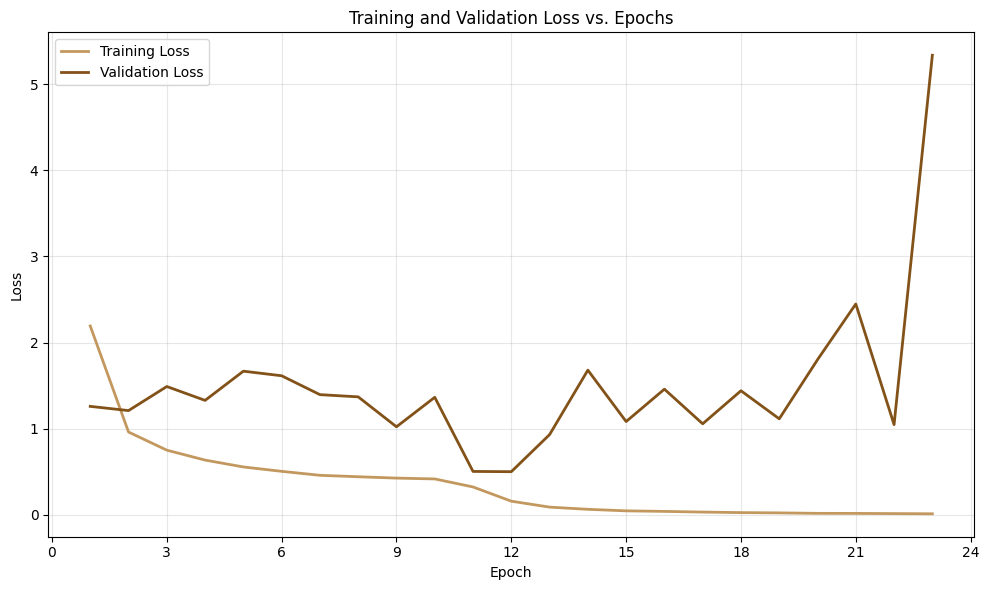

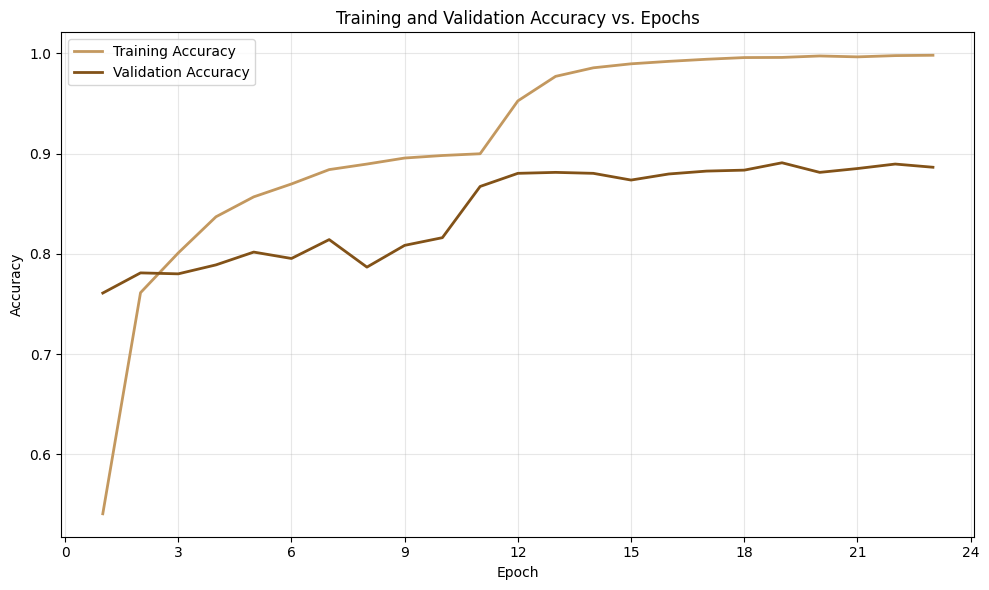

In [14]:
# Plots the training and validation curves for a given metric (Loss or Accuracy)
def plot_training_metric(history, metric="Loss"):
    values_train = history[f"train_{metric.lower()}"]
    values_val = history[f"val_{metric.lower()}"]
    epochs = range(1, len(values_train) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, values_train, label=f"Training {metric}", linewidth=2, color="#C3985F")
    plt.plot(epochs, values_val, label=f"Validation {metric}", linewidth=2, color="#825218")

    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.title(f"Training and Validation {metric} vs. Epochs")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot the training and validation loss and accuracy curves
plot_training_metric(history, "Loss")
plot_training_metric(history, "Accuracy")

In [15]:
# Returns the predictions and probabilities for a batch of images
def predict_batch(model, images, device, k=1):
    # Switch the model into evaluation mode
    model.eval()

    # Disable gradient computation for evaluation
    with torch.no_grad():
        # Move the images to the selected device
        images = images.to(device)

        # Run the model and convert the logits to probabilities
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        # If requesting only the top-1 prediction...
        if k == 1:
            # Retrieve the highest-probability class and return the predictions and probabilities
            preds = torch.argmax(probs, dim=1)
            return preds.cpu(), probs.cpu()

        # Otherwise...
        else:
            # Retrieve and return the top-k predictions and their probabilities
            top_probs, top_idxs = probs.topk(k, dim=1)
            return top_idxs.cpu(), top_probs.cpu()

# Returns the predictions, targets, and probabilities for an entire dataset
def predict_dataset(model, dataloader, device, k=1, as_tensor=False):
    # Initialize lists to store all the predictions, targets, and probabilities
    all_preds = []
    all_targets = []
    all_probs = []

    # Switch the model into evaluation mode
    model.eval()

    # Disable gradient computation for evaluation
    with torch.no_grad():
        # Load the data in batches
        for images, labels in dataloader:
            # Run batch prediction and record the results
            preds, probs = predict_batch(model, images, device, k)
            all_preds.append(preds)
            all_probs.append(probs)
            all_targets.append(labels.cpu())

    # Concatenate all the batch outputs into full-dataset tensors, optionally convert them to lists, and return them
    if as_tensor:
        return (torch.cat(all_preds), torch.cat(all_targets), torch.cat(all_probs))
    else:
        return (torch.cat(all_preds).tolist(), torch.cat(all_targets).tolist(), torch.cat(all_probs).tolist())

# Returns the prediction and probabilities for a single image
def predict_single(model, img_path, transform, device, k=1):
    # Switch the model into evaluation mode
    model.eval()

    # If the file at the specified path is a valid image...
    if is_image(img_path):
        # Load and preprocess the image
        img = Image.open(img_path).convert("RGB")
        tensor = transform(img).unsqueeze(0)        # Create a batch of size 1

        # Run batch prediction
        preds, probs = predict_batch(model, tensor, device, k)

        # Extract and return the results for the single image
        if k == 1:
            return preds[0].item(), probs[0].tolist()
        else:
            return preds[0].tolist(), probs[0].tolist()

# Computes the top-k accuracy of the model on a given dataset
def compute_accuracy_topk(model, dataloader, device, k=1):
    # Get the predictions and targets for the entire dataset
    preds, targets, _ = predict_dataset(model, dataloader, device, k=k, as_tensor=True)

    # For top-1 accuracy, count exact matches between the predicted and true labels
    if k == 1:
        correct = (preds == targets).sum().item()
        total = targets.size(0)
        return correct / total

    # For top-k accuracy, count samples where the true label appears in the top-k predictions
    else:
        correct = 0
        for i in range(len(targets)):
            if targets[i].item() in preds[i]:
                correct += 1
        return correct / len(targets)

# Computes the accuracy per dog breed for corresponding predictions and targets
def compute_accuracy_per_breed(preds, targets):
    # Initialize a dictionary to store breed statistics (correct and total counts)
    breed_stats = {}

    # Iterate over all the predictions and targets
    for true_breed, pred_breed in zip(targets, preds):
        # Add the current breed to the dictionary if it's not already present
        if true_breed not in breed_stats:
            breed_stats[true_breed] = {"correct": 0, "total": 0}

        # Update the correct and total counts for the current breed
        if pred_breed == true_breed:
            breed_stats[true_breed]["correct"] += 1
        breed_stats[true_breed]["total"] += 1

    # Convert the counts to accuracy for each breed
    breed_accuracy = {
        breed: stats["correct"] / stats["total"]
        for breed, stats in breed_stats.items()
    }

    # Return the accuracy-per-breed dictionary
    return breed_accuracy

# Plots a confusion matrix for the given predictions and targets
def plot_confusion_matrix(preds, targets, class_names, normalize=False, figsize=(12, 10)):
    # Compute the confusion matrix
    cm = confusion_matrix(targets, preds, labels=class_names, normalize='true' if normalize else None)

    # Plot the heatmap
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        cm,
        annot=False,
        cmap="Blues",
        xticklabels= False,
        yticklabels=False
    )
    ax.set_xticks(range(len(class_names)))
    ax.set_yticks(range(len(class_names)))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix" + (" (Normalized)" if normalize else ""))
    plt.tight_layout()
    plt.show()

# Plots a confusion matrix for the k most confused classes (lowest per-class accuracy)
def plot_topk_confusion_matrix(preds, targets, acc_per_breed=None, k=10, normalize=False, figsize=(10, 8)):
    # Compute the accuracy per breed as necessary
    if acc_per_breed is None:
        acc_per_breed = compute_accuracy_per_breed(preds, targets)

    # Sort the breeds by accuracy (ascending) and select the k worst-performing breeds
    sorted_breeds = sorted(acc_per_breed.items(), key=lambda x: x[1])
    worst_breeds = [breed for breed, _ in sorted_breeds[:k]]

    # Compute the confusion matrix restricted to these breeds
    cm = confusion_matrix(targets, preds, labels=worst_breeds, normalize='true' if normalize else None)

    # Plot the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=worst_breeds, yticklabels=worst_breeds)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(
        f"Confusion Matrix for the {k} Lowest-Accuracy Breeds"
        + (" (Normalized)" if normalize else "")
    )
    plt.tight_layout()
    plt.show()

# Returns a list of class names from the class mapping JSON file
def get_class_names(class_mapping_path="class_mapping.json"):
    with open(class_mapping_path, "r") as f:
        class_mapping = json.load(f)
    return [class_mapping[key] for key in sorted(class_mapping.keys())]

# Converts a class index (or a list of class indexes) to human-readable dog breed names
def class_idx_to_breed(class_idx, class_mapping_path="class_mapping.json"):
    # Load the class mapping from the JSON file
    with open(class_mapping_path, "r") as f:
        class_mapping = json.load(f)

    # If a single index is provided, convert it to a list for uniform processing
    single_input = False
    if isinstance(class_idx, int):
        class_idx = [class_idx]
        single_input = True

    # Map each class index to its corresponding dog breed name
    keys = sorted(class_mapping.keys())
    breed_names = [class_mapping[keys[idx]] for idx in class_idx]

    # If the input was a single index, return a single breed name
    if single_input:
        return breed_names[0]

    # Otherwise, return a list of breed names
    return breed_names

In [16]:
# Load the best model
checkpoint = torch.load(BEST_MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [17]:
# Evaluate the model on the validation dataset and report its loss and accuracy
val_loss, val_acc = evaluate(model, data_loaders["valid"], device, criterion)
print(f"Final Validation Loss: {val_loss:.4f}, Final Validation Accuracy: {val_acc:.4f}")

Final Validation Loss: 1.1132, Final Validation Accuracy: 0.8908


In [18]:
# Evaluate the model on the test dataset and report its loss and accuracy
test_loss, test_acc = evaluate(model, data_loaders["test"], device, criterion)
print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_acc:.4f}")

Final Test Loss: 0.6017, Final Test Accuracy: 0.8841


In [19]:
# Compute and report the top-5 accuracy on the test dataset
top5_test_acc = compute_accuracy_topk(model, data_loaders["test"], device, k=5)
print(f"Final Test Top-5 Accuracy: {top5_test_acc:.4f}")

Final Test Top-5 Accuracy: 0.9882


In [20]:
# Get the predictions and targets for the test dataset
preds, targets, _ = predict_dataset(model, data_loaders["test"], device)
preds, targets = class_idx_to_breed(preds), class_idx_to_breed(targets)

In [21]:
# Compute and report the accuracy per dog breed
accuracy_per_breed = compute_accuracy_per_breed(preds, targets)
print("Accuracy per Breed: \n", accuracy_per_breed)

Accuracy per Breed: 
 {'Chihuahua': 0.9130434782608695, 'Japanese Chin': 0.9642857142857143, 'Maltese': 1.0, 'Pekingese': 0.782608695652174, 'Shih Tzu': 0.8181818181818182, 'Cavalier King Charles Spaniel': 0.9655172413793104, 'Papillon': 0.9333333333333333, 'Toy Terrier': 0.9615384615384616, 'Rhodesian Ridgeback': 0.9230769230769231, 'Afghan Hound': 0.9444444444444444, 'Basset Hound': 0.8148148148148148, 'Beagle': 0.6, 'Bloodhound': 0.896551724137931, 'Bluetick Coonhound': 0.9230769230769231, 'Black and Tan Coonhound': 0.875, 'Treeing Walker Coonhound': 0.8260869565217391, 'English Foxhound': 0.7916666666666666, 'Redbone Coonhound': 0.8260869565217391, 'Borzoi': 0.9565217391304348, 'Irish Wolfhound': 0.8181818181818182, 'Italian Greyhound': 0.9285714285714286, 'Whippet': 0.9310344827586207, 'Ibizan Hound': 0.896551724137931, 'Norwegian Elkhound': 1.0, 'Otterhound': 0.8695652173913043, 'Saluki': 0.9666666666666667, 'Scottish Deerhound': 0.9714285714285714, 'Weimaraner': 1.0, 'Staffordsh

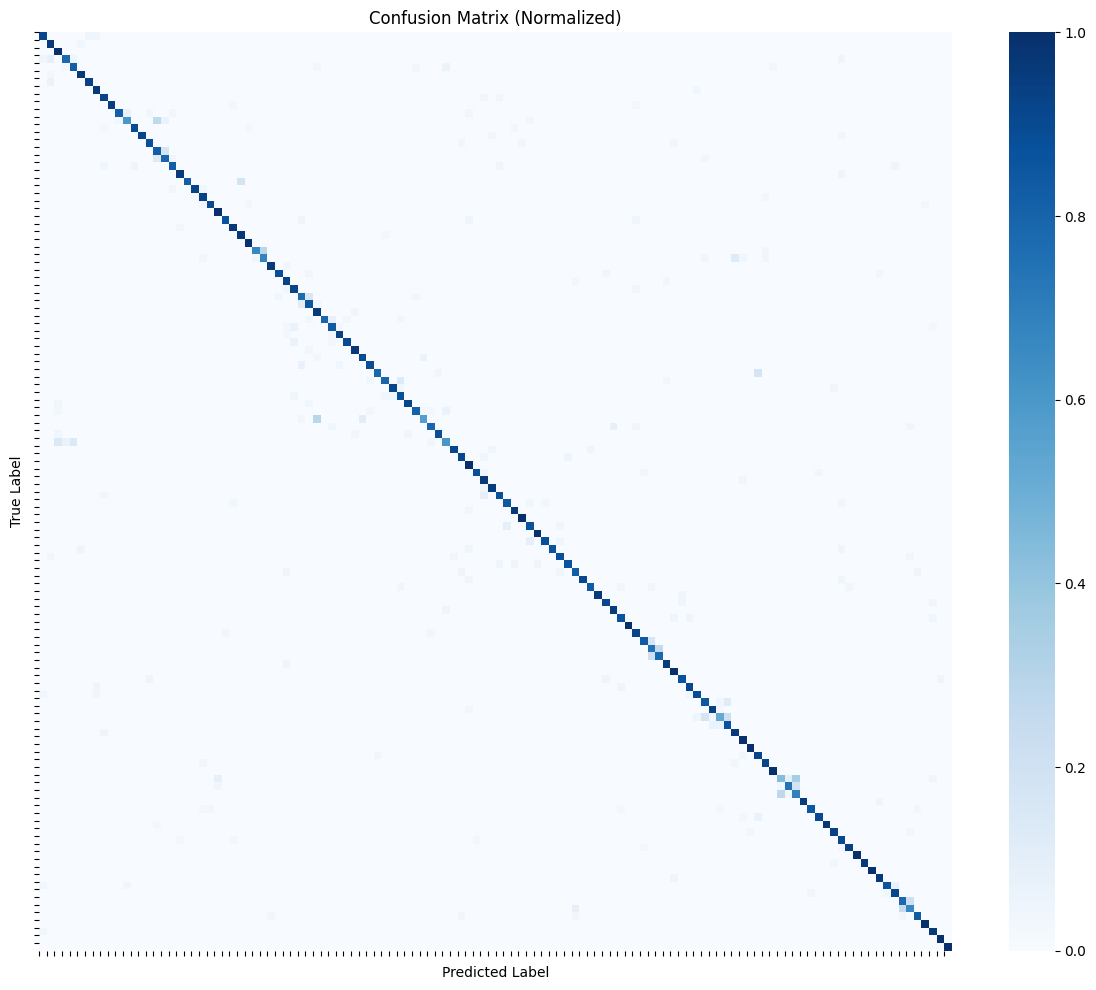

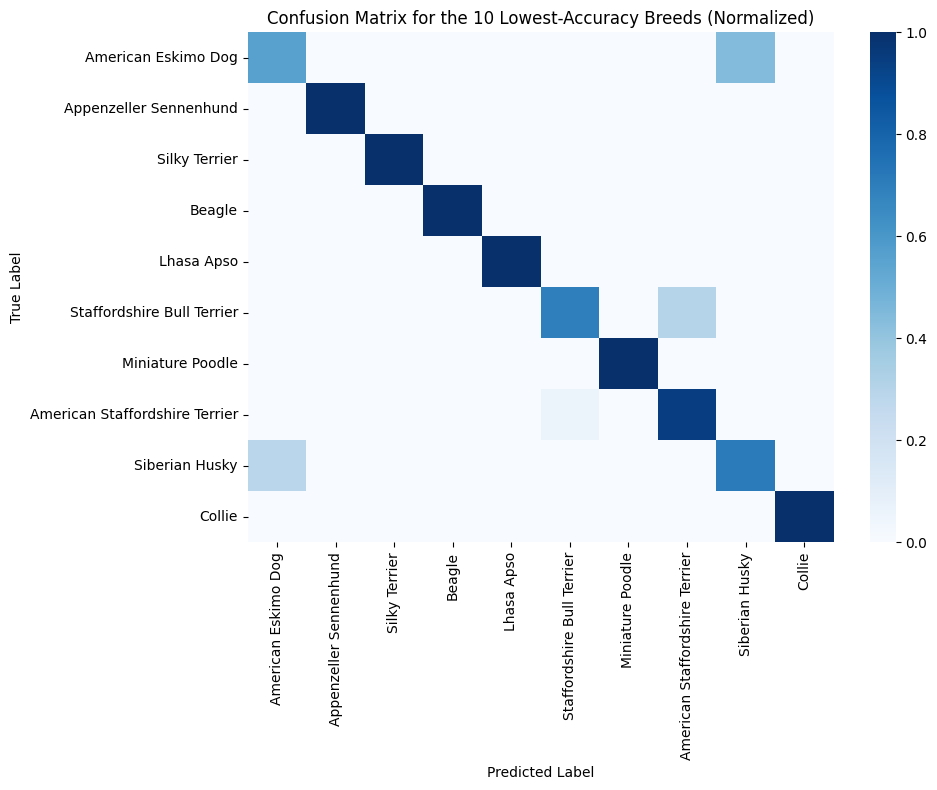

In [22]:
# Plot the full and top-10 confusion matrices
class_names = get_class_names()
plot_confusion_matrix(preds, targets, class_names, normalize=True)
plot_topk_confusion_matrix(preds, targets, accuracy_per_breed, normalize=True)

In [23]:
# Create a list of image paths from the additional_images directory
directory = "additional_images"
exts = {".jpg", ".jpeg", ".png"}
image_paths = [
    os.path.join(directory, f)
    for f in os.listdir(directory)
    if os.path.splitext(f.lower())[1] in exts
]

# Output a prediction for each image in the directory
for img_path in image_paths:
    # Extract the image name for display
    base = os.path.basename(img_path)
    name = os.path.splitext(base)[0].capitalize()

    # Predict the dog breed for the current image
    pred_idx, _ = predict_single(model, img_path, image_transforms["valid_test"], device, k=1)
    pred_breed = class_idx_to_breed(pred_idx)

    # Output the prediction results
    print(f"{name}: {pred_breed}")

Winnie: Great Dane
Watson: Italian Greyhound
Flash: Bluetick Coonhound
Tahlia: Great Dane
Foxy: American Staffordshire Terrier
